### Import necessary packages

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle

from model import ImageCaptionModel
from decoder import TransformerDecoder

### Explore the data

In [2]:
with open('../memes900k/data.p', 'rb') as data_file:
    data_dict = pickle.load(data_file)

# As mentioned in the handout, this assignment has 5 captions per image. This block of code 
# expands the image_feature lists to have 5 copies of each image to correspond to each of their captions 
feat_prep = lambda x: np.repeat(np.array(x).reshape(-1, 2048), 50, axis=0)
img_prep  = lambda x: np.repeat(x, 5, axis=0)

## Captions; preprocessed sentences with 20 window size
train_captions  = np.array(data_dict['train_captions']);            print('train_captions:  ', train_captions.shape)
test_captions   = np.array(data_dict['test_captions']);             print('test_captions:   ', test_captions.shape)

## 2048-D resnet embeddings of images.
train_img_feats = feat_prep(data_dict['train_image_features']);     print('\ntrain_img_feats: ', train_img_feats.shape)
test_img_feats  = feat_prep(data_dict['test_image_features']);      print('test_img_feats:  ', test_img_feats.shape)

## Small subset of actual images for visualization purposes. 
## These are just for the first 100 images of each (clones 5 times)
train_images    = img_prep(data_dict['train_images']);              print('\ntrain_images:    ', train_images.shape)
test_images     = img_prep(data_dict['test_images']);               print('test_images:     ', test_images.shape)

## Conversion dictionaries to go between word and label index
word2idx        = data_dict['word2idx']
idx2word        = data_dict['idx2word']

train_captions:   (12000, 21)
test_captions:    (3000, 21)

train_img_feats:  (12000, 2048)
test_img_feats:   (3000, 2048)

train_images:     (500, 300, 300, 3)
test_images:      (300, 300, 300, 3)


Since the images take up a lot of data, we only kept a sliver of the original images. Feel free to update the preprocessing to retain all of the images if you'd like. Below is a visualization of some of the data:

Caption 1: <start> ll just play for few minutes before going to bed aaaand it dawn <end> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> had chance to win aaannd it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> weekend just started aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> finally in relationship with the person you love aaaaaand its gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> poops reaches for toilet paper aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


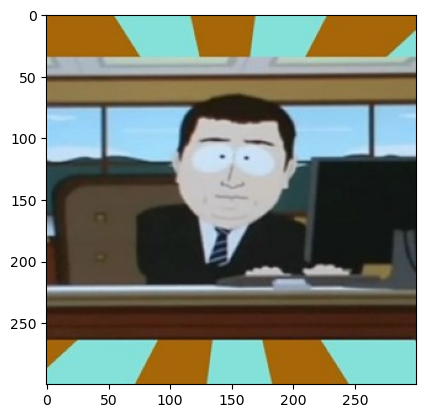

Caption 1: <start> had good idea for meme aaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> had my chance to hit it aaand its gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> wild abra appears aaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> just got paid and its gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> had really great dream last night aaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


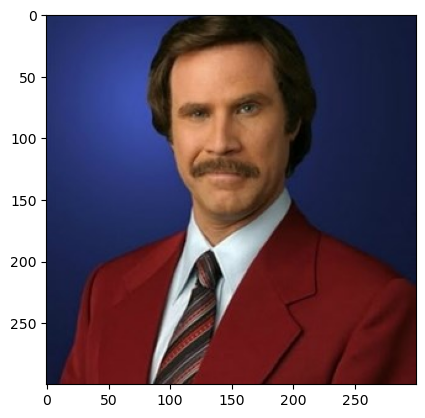

Caption 1: <start> toronto has lead aaaaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> just found out about flappy bird aaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> here is obama with your tax payers money aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> ve got good idea aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> had some hope aaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


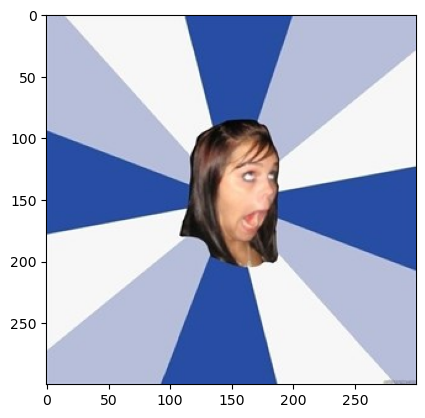

Caption 1: <start> october is here aaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> the mets have the lead going into the inning aaaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> just got my paycheck aaaand its gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> ll just load save annddd surrounded by deathclaws <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> moment ago felt compelled to do something nice for you and it gone <end> <pad> <pad> <pad> <pad> <pad> <pad>


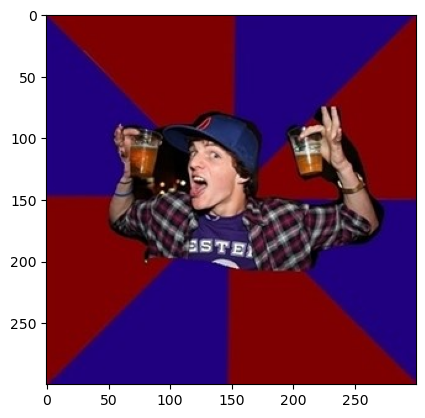

Caption 1: <start> here some nice really warm weather aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> you made another religious post aaaaaand you re gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> ll just look up my respect for you aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> okay just go inside go to the deli get the meat and cheese aaannd forgot my wallet <end> <pad> <pad>
Caption 5: <start> twinkies aaaand they re gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


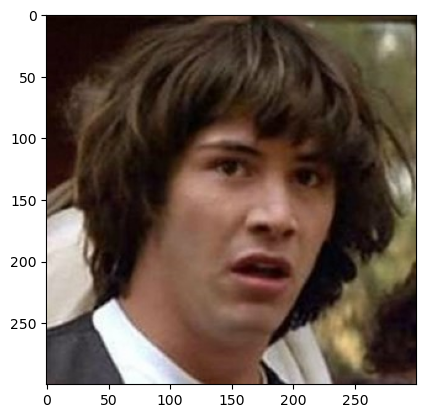

In [20]:
for i in range(5):
    for j in range(5):
        print(f'Caption {j+1}:', ' '.join([idx2word[idx] for idx in train_captions[i * 5 + j]]))
    plt.imshow(train_images[i * 5])
    plt.show()

### Run the model
Pay attention to some of the required arguments.

In [3]:
!python assignment.py

usage: assignment.py [-h] --task {train,test,both} --data DATA
                     [--epochs EPOCHS] [--lr LR]
                     [--optimizer {adam,rmsprop,sgd}]
                     [--batch_size BATCH_SIZE] [--hidden_size HIDDEN_SIZE]
                     [--window_size WINDOW_SIZE] [--chkpt_path CHKPT_PATH]
                     [--check_valid]
assignment.py: error: the following arguments are required: --task, --data


Running with the `both` task to train, save, and test the  model at the same time.

In [6]:
# run the transformer
!python assignment.py --task both --data ../memes900k/data.p --epochs 3 --lr 0.0005 --chkpt_path ../transform_model

[Batch 120/120]	 loss=7.048	 acc: 0.108	 perp: 1150.023
[Valid 30/30]	 loss=6.457	 acc: 0.132	 perp: 637.401
[Batch 120/120]	 loss=5.975	 acc: 0.173	 perp: 393.326
[Valid 30/30]	 loss=5.975	 acc: 0.171	 perp: 393.430
[Batch 120/120]	 loss=5.125	 acc: 0.254	 perp: 168.123
[Valid 30/30]	 loss=5.859	 acc: 0.187	 perp: 350.426
Model saved to ../transform_model


### Visualization

In [9]:
from assignment import parse_args, load_model
from decoder import TransformerDecoder

args = parse_args('--task both --data ../memes900k/data.p'.split())
args.chkpt_path = '../transform_model'
tra_imcap = load_model(args)
tra_imcap.summary()

Model loaded from '../transform_model'
Model: "image_caption_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_decoder (Trans  multiple                  7269343   
 formerDecoder)                                                  
                                                                 
Total params: 7269343 (27.73 MB)
Trainable params: 7269343 (27.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now that we have our model, we need to be able to actually access the attention matrix that gets generated by out model. So that we can visualize it, right? Unfortunately for us, some convenience methods that allow you to make arbitrary model slices (i.e. the Functional API) are forfeit since our model is a subclass (in contrast to a sequential or functional). 

However, we can still dig into the model and force out way to computing the components we want. Our weights have been saved, after all...

The following block of code visualizes the decoder self-attention for a random images in the test dataset. 


Move your mouse over the words in the left hand column, and see how much attention your decoder self-attention layer pays to each word in the sentance as it encodes each word.

Image number: 295
self_atten


<IPython.core.display.Javascript object>

self_context_atten


<IPython.core.display.Javascript object>

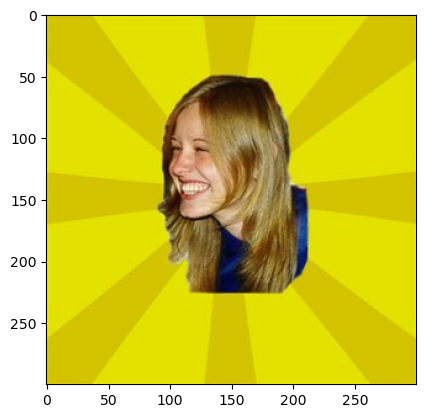

In [13]:
import tensorflow as tf
from vis_utils import plot_decoder_text_attention
import numpy as np

index = np.random.choice(np.array(list(range(0,300,5))))

caption    = test_captions[index][:-1]
image_feat = test_img_feats[index]
image      = test_images[index]

print("Image number:", index)

def get_attention(tra_imcap, image_feat, caption):
    encoded_images = tra_imcap.decoder.image_embedding(tf.expand_dims(image_feat, 1))
    captions = tra_imcap.decoder.encoding(caption)
    self_atten = tra_imcap.decoder.decoder.self_atten(captions, captions, captions)
    self_context_atten = tra_imcap.decoder.decoder.self_context_atten(encoded_images, encoded_images, captions)

    return self_atten, self_context_atten


def vis_attention(atten_mtx, image_features, caption, idx2word):
    caption_words = [idx2word[idx] for idx in caption]
    end_sentance_index = caption_words.index('<end>') if '<end>' in caption_words else 20
    caption_words = caption_words[:end_sentance_index]
    AttentionMatrix = atten_mtx[:, :end_sentance_index, :end_sentance_index]
    AttentionMatrix = tf.reshape(AttentionMatrix, (1, 1, 1, end_sentance_index, end_sentance_index))
    plot_decoder_text_attention(attention=AttentionMatrix, tokens=caption_words)

self_atten, self_context_atten = get_attention(
    tra_imcap, tf.expand_dims(image_feat, 0), tf.expand_dims(caption, 0)
)

print("self_atten")
vis_attention(self_atten, image_feat, caption, idx2word)

print("self_context_atten")
vis_attention(self_context_atten, image_feat, caption, idx2word)

plt.imshow(image)
plt.show()

### Caption Generation
Now that you have trained both of your models, it's time to use them to generate original captions for images in the testing set. First, the model is given the <start\> token and asked to generate probabilites for the next word in the sequence. The next token is chosen by sampling from that probability. This process repeats until the model generates the <end\> token, or the maximum sequence length is reached.

 



There is still one piece of this equation missing. The tokens are sampled from the probabilities your models generate, but your models were required to output logits, not probabilities. This is becasue this assignment, like many NLP models, uses temperature as a parameter in text generation. If the models sampled from  probabilies calculated by simply applying softmax to the logits, then the probability of the most likely word will usually be very high and the models will usually genrate the same, most probable caption every time. We use the temperature as a parameter to even out the probabilites so the model produces more 'creative' captions. This is done by dividing the logits by the temperature parameter before applying softmax. Higher temprature values will give a more creative captiong, while temprature values closer to 0 will be more greedy. Check out [this](https://lukesalamone.github.io/posts/what-is-temperature/) article for a demonstration and further explaination of temprature in NLP models.


The following blocks of code will generate a caption for the image currently selected for the attention visualization above. Try playing around with different temperature values and see how it changes the captions your models generate

In [11]:
def gen_caption_temperature(model, image_embedding, wordToIds, padID, temp, window_length):
    """
    Function used to generate a caption using an ImageCaptionModel given
    an image embedding. 
    """
    idsToWords = {id: word for word, id in wordToIds.items()}
    unk_token = wordToIds['<unk>']
    caption_so_far = [wordToIds['<start>']]
    while len(caption_so_far) < window_length and caption_so_far[-1] != wordToIds['<end>']:
        caption_input = np.array([caption_so_far + ((window_length - len(caption_so_far)) * [padID])])
        logits = model(np.expand_dims(image_embedding, 0), caption_input)
        logits = logits[0][len(caption_so_far) - 1]
        probs = tf.nn.softmax(logits / temp).numpy()
        next_token = unk_token
        attempts = 0
        while next_token == unk_token and attempts < 5:
            next_token = np.random.choice(len(probs), p=probs)
            attempts += 1
        caption_so_far.append(next_token)
    return ' '.join([idsToWords[x] for x in caption_so_far][1:-1])


In [14]:
temperature = 0.2
gen_caption_temperature(tra_imcap, image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size)


'hey girl you have you re gonna have bad time'

**NOTE:** You may want to try a different image. Sometimes you get really unlucky with random selection.

## Generating Sentences for Training Data 

C1: downloading game on the pirate bay finds out its fake torrent containing porno
C2: can make counterpoint in an argument better call him troll
C3: these cancer memes are so funny wait do have cancer
C4: gets his first kill in call of duty after dying over times
C5: know how to fly in single player creative minecraft such hacker
TRA: emp the fuck


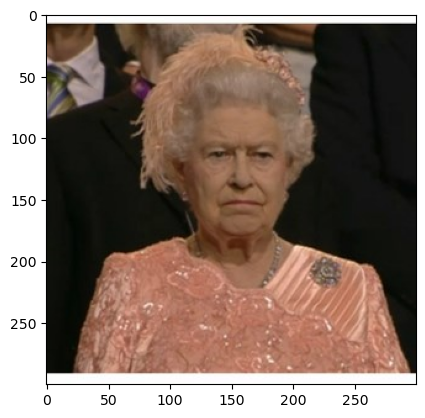

C1: product of canada may contain defects
C2: is supposedly still looks
C3: gets caught sucking dick doesn deny it
C4: receives speeding ticket his car didn move but he drove his bf cock fast in the backseat
C5: gets caught red handed sucking cock keeps sucking cock
TRA: emp you have no power here


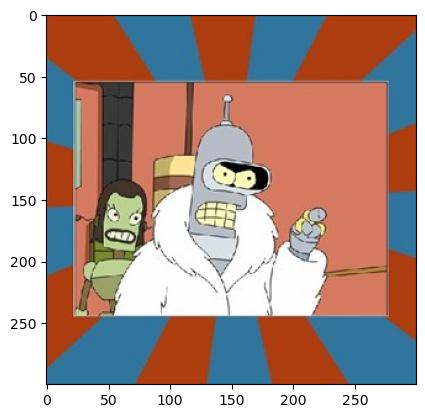

C1: has girlfriend flirts with other girls
C2: get well soon or ll start singing
C3: like fan slapped
C4: must hide people are trying to kill me
C5: so canada this is how you declare war
TRA: what do you mean you have to be like to be like


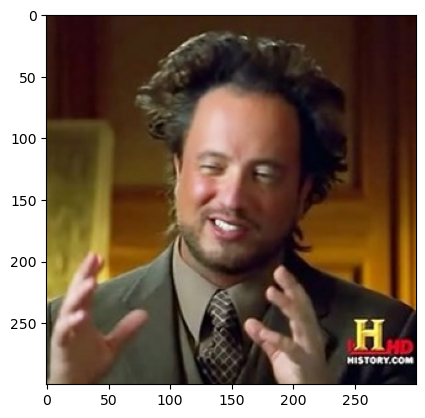

C1: what if it really was cool story and she wants me to tell it again
C2: what if my upvote is not just my upvote but also other upvotes and other downvotes
C3: what if the mayans were the biggest trolls ever
C4: what if keanu made this meme just so people will remember him
C5: what if pinky was also genius and was stopping brain from taking over the world on purpose
TRA: what if told you could stop trying to the world not going to the world


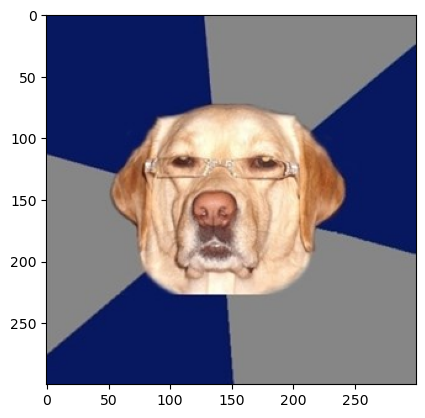

C1: this is the last time blow my boyfriend
C2: auto tune is not talent your argument is invalid
C3: know ugly but my fans don
C4: bieber australian for queer
C5: pigeon shits in hair doesnt know for week
TRA: what do you mean you have to be like to be like


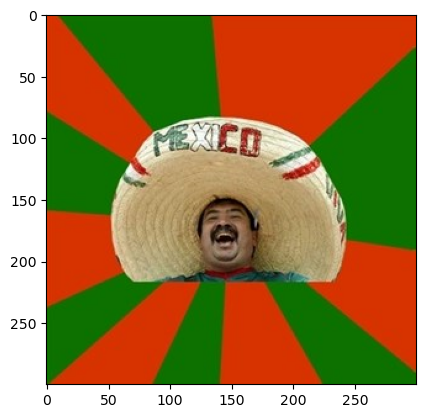

C1: former boss visits your new place of employment you have no power here
C2: math teacher out of school ha you have no power here
C3: yo big ass you have no power here
C4: day you leave school insults teacher you have no power here
C5: hahah you have school
TRA: you have no power here


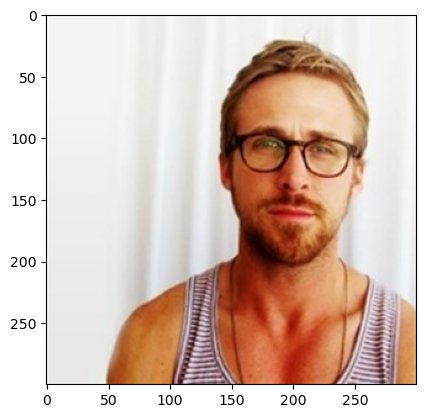

C1: there something slightly different with each conspiracy keanu picture
C2: what if someone simply walks into mordor
C3: what if tupac is alive and we re just holograms
C4: what if am retarded and everyone acts like im normal just to make me feel normal
C5: what if we ve already died and the earth is hell
TRA: what if told you could stop trying to the world not going to the world


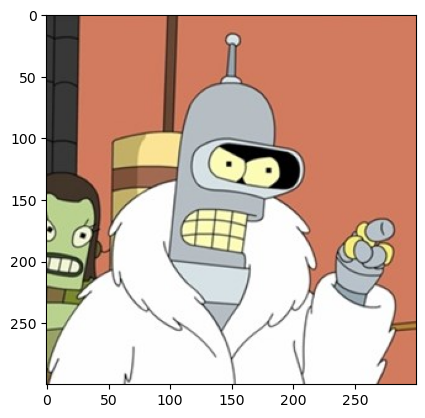

C1: hipsters you have no power here ha ha ha
C2: hashtags on facebook it seems you do have power here
C3: this is internet god has no power here
C4: you have no power here faggot
C5: parents coming to my house they have no power here
TRA: you have no power here


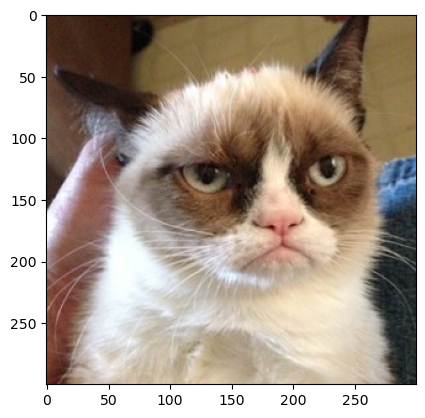

C1: slipped her roofie accidently drinks her beer
C2: lost my virginity while listening to dave matthews band
C3: just holding these until the cool kids get back
C4: dude if you mix with you get
C5: shot of vodka wasted
TRA: gets everywhere


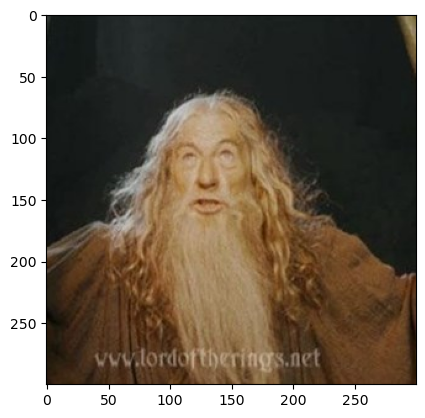

C1: generation the baby boomers cheated you out of billions and billions of dollars
C2: happy birth day daniel welcome to the dirty club
C3: going to need you to take your opinion and shove it waaay up inside your butthole
C4: cnn news finally respected journalist
C5: happy birthday gypsy bitch
TRA: when you re gonna have bad time


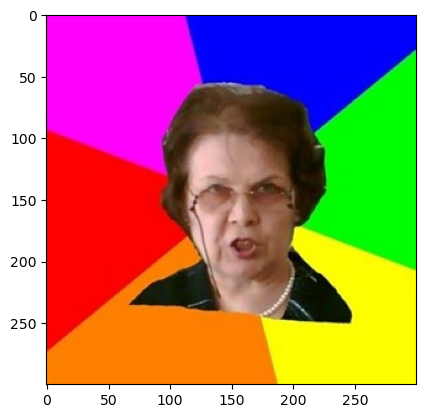

In [17]:
temperature = 0.05
indices = np.random.choice(np.array(list(range(0, 500, 5))), 10, replace=False)
for i in indices:
    curr_image_feat = train_img_feats[i]
    curr_image      = train_images[i]
    for j in range(5):  ## Display all of the captions trained on
        words = [idx2word[x] for x in train_captions[i+j][:-1] if idx2word[x] not in ('<pad>', '<start>', '<end>')]
        print(f'C{j+1}:', ' '.join(words))
    print('TRA:', gen_caption_temperature(tra_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size))
    plt.imshow(curr_image)
    plt.show()

### Trying out on things in testing set!

C1: sick post dude fuck you
C2: oh <unk> thanks guys love you too
C3: cold news room just like my heart
C4: you must construct additional pylons
C5: no none of that
TRA: you have no power here


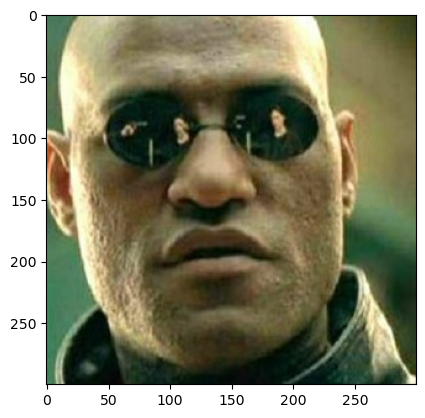

C1: dont always use the wrong meme challenge accepted
C2: don always call but when do ask the operator what she wearing
C3: don always see but when do it what you did there
C4: don always post on memegenerator but when do it because it working
C5: don always talk to <unk> state graduates but when do ask for large fries
TRA: so you re telling me that you re gonna have bad time


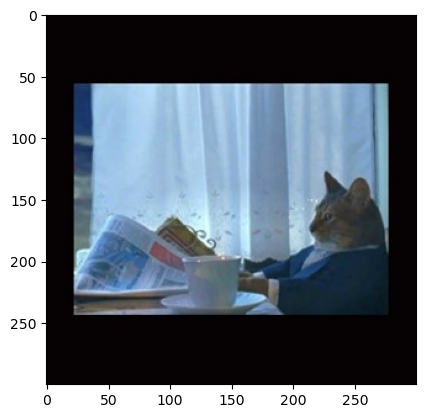

C1: bacon and fish my bed life
C2: you complain about girl having sex then want <unk> seconds but that none of my business
C3: still <unk> for big question yet you open your legs <unk> than <unk> ocean
C4: you didn pay your child support but bought the iphone but that none of my business
C5: let me sip my tea while read the comments
TRA: why can hold all these


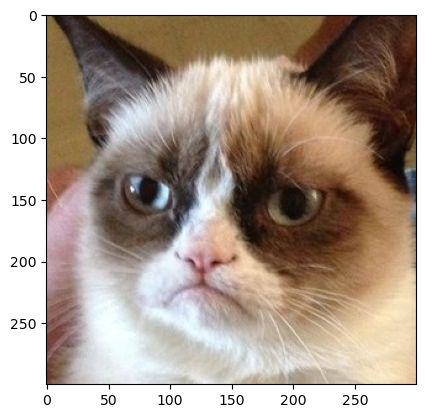

C1: why isn this fish drowning
C2: dude its your mum no thats cellphone
C3: someone pass me slice of coke
C4: gets <unk> funeral home smells like weed
C5: wash your hands before you order the pizza
TRA: hey girl you re gonna have no power here


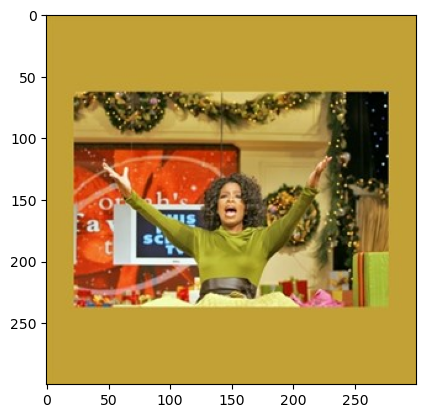

C1: bangs pig every night can figure out why they don have kids
C2: the face give when my boss gives me task with million steps
C3: ignore the frog ignored your private message
C4: you think you had hard day just try living with someone hand constantly up your ass
C5: you know <unk> and social justice isn always the solution
TRA: why can hold all these


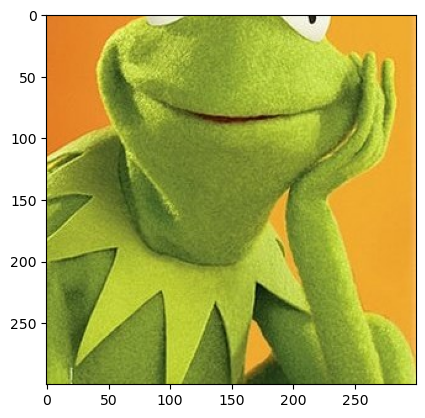

C1: life is like box of chocolates it lasts half as long for fat people
C2: my face when people don have <unk>
C3: like good neighbor stay over there
C4: you make joke every one laughs then some one says it again no
C5: hated my life before it was emo
TRA: when you have you have to be like to be like


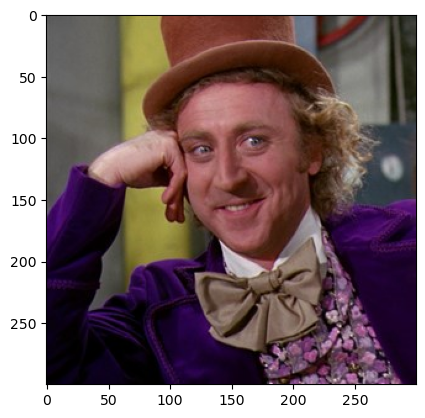

C1: dont always make bad memes but when do cant delete them
C2: don always get drunk but when do wake up in strange place dressed as woman
C3: dont always make millions off of scams but when do <unk> in public
C4: don always talk to <unk> graduates but when do ask for extra fries
C5: people dont always post on my wall but when they do it <unk> because it my birthday
TRA: you re gonna have bad


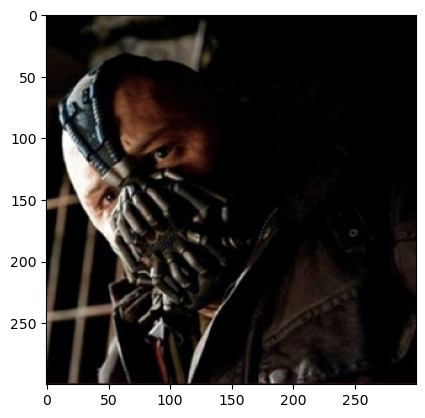

C1: germany please stop <unk> <unk>
C2: itunes please <unk>
C3: parents please give me money
C4: please upvote this meme
C5: please go out with me again
TRA: emp you have no power here


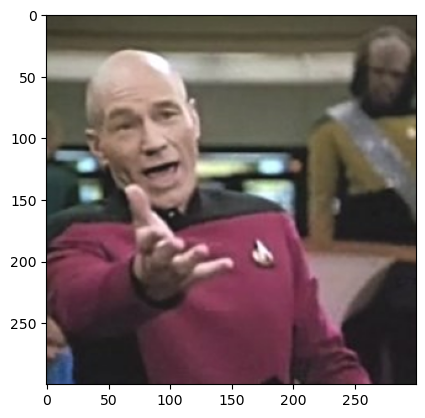

C1: don always correct people grammar but when do google that shit first
C2: dont always drink milk but when do prefer <unk> titties
C3: don always use <unk> <unk> but when do it hits five time
C4: dont always make good meme this is perfect <unk>
C5: dont always have <unk> dont always have <unk>
TRA: so you re telling me that you re gonna have bad time


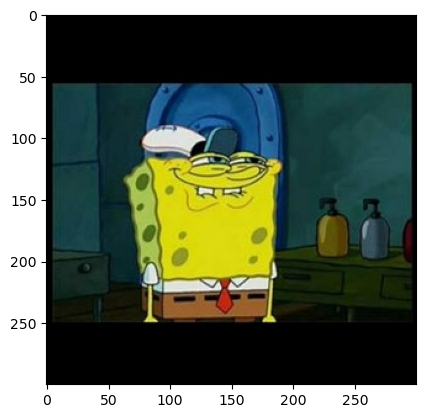

C1: don always read memes but when do it hard to stop
C2: don always get <unk> at burger king but when do it whopper
C3: don always make meme at meme generator but when do tell someone to click the up arrow
C4: don always launch internet explorer but when do it by accident
C5: don always use internet explorer but when do its to download google <unk>
TRA: you re gonna have bad


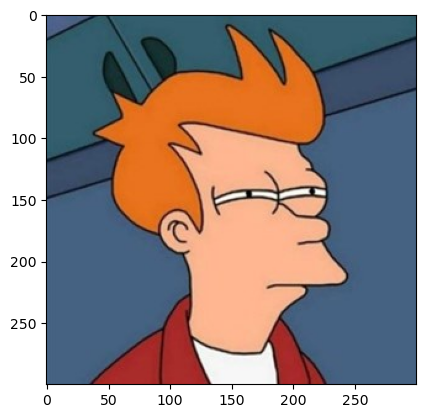

In [19]:
temperature = 0.05
indices = np.random.choice(np.array(list(range(0, 300, 5))), 10, replace=False)
for i in indices:
    curr_image_feat = test_img_feats[i]
    curr_image      = test_images[i]
    for j in range(5):  ## Display all of the captions trained on
        words = [idx2word[x] for x in test_captions[i+j][:-1] if idx2word[x] not in ('<pad>', '<start>', '<end>')]
        print(f'C{j+1}:', ' '.join(words))
    print('TRA:', gen_caption_temperature(tra_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size))
    plt.imshow(curr_image)
    plt.show()

# Conclusion!
Congrats! You have finished this assignment! Below, put down your favorite captions that your RNN and Transformer models both generated!  

why can hold all these


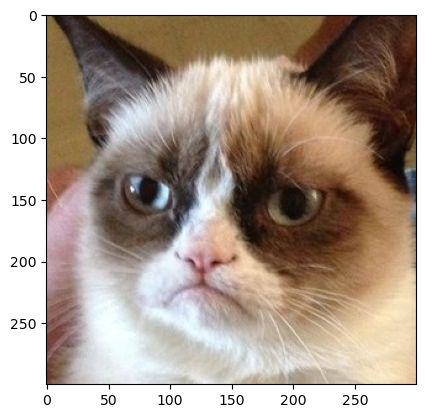

In [23]:
tra_image_index = 23#?
tra_caption = gen_caption_temperature(tra_imcap, test_img_feats[tra_image_index], word2idx, word2idx['<pad>'], temperature, args.window_size)

print(tra_caption)
plt.imshow(test_images[tra_image_index])
plt.show()